> This notebook is solely meant to generate evaluation metrics for the dataset with SMOTE applied.
> 
> Hence, the discussion sections for this notebook have been removed.
> 
> To see the justifications and discussions, refer to `predictive-modelling.ipynb` (predictive modelling on the original dataset).

# Predicting Booking Status with SMOTE


In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
# Define a fixed random state
RANDOM_STATE = 1

## Data Cleaning

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
hotel_df_random_oversampled = pd.read_csv("./data/hotel-reservations-SMOTE.csv")

In [5]:
# Split X and y columns
X = hotel_df_random_oversampled.drop('booking_status', axis=True)
y = hotel_df_random_oversampled['booking_status']

In [6]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

## Utility Functions

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [8]:
def evaluate_model(model_name, y_test, y_pred):
  model_accuracy = accuracy_score(y_test, y_pred)
  model_f1 = f1_score(y_test, y_pred)
  model_precision = precision_score(y_test, y_pred)
  model_recall = recall_score(y_test, y_pred)

  return pd.DataFrame([[model_name, model_accuracy, model_f1, model_precision, model_recall]], columns=['Model', 'Accuracy Score', 'F1 score', 'Precision', 'Recall'])

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [10]:
# Create a scaler object
scaler = StandardScaler()

# Fit the scaler on the training set
scaler.fit(X_train)

# Scale both the training and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# Train and fit the model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled , y_train)

LogisticRegression()

In [12]:
# Predict on the test set
lr_y_pred = lr_model.predict(X_test_scaled)

### Evaluation

<Axes: >

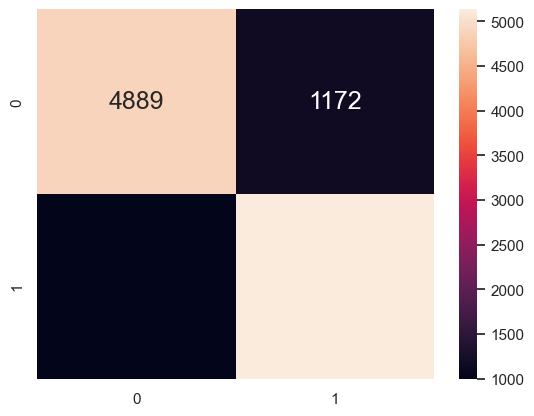

In [13]:
lr_confusion_matrix = confusion_matrix(y_test, lr_y_pred)

sb.heatmap(lr_confusion_matrix, annot=True, fmt=".0f", annot_kws={"size": 18})

In [14]:
lr_results = evaluate_model('Logistic Regression', y_test, lr_y_pred)

lr_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Logistic Regression,0.821976,0.825496,0.814175,0.837137


## K-Nearest Neighbors (KNN)

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
# Train and fit the model
knn_model = KNeighborsClassifier().fit(X_train, y_train)

In [17]:
# Predict on the test set
knn_y_pred = knn_model.predict(X_test.values)

/opt/homebrew/anaconda3/envs/DSAI/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


### Evaluation

<Axes: >

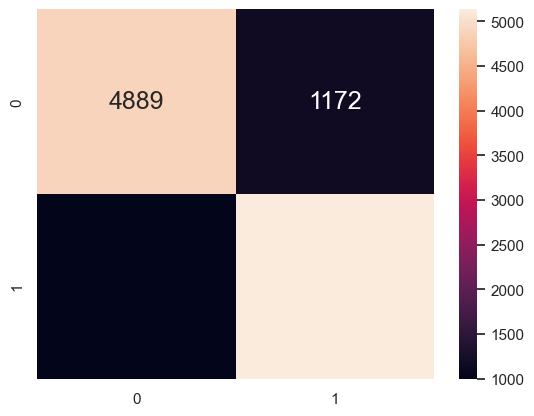

In [18]:
knn_confusion_matrix = confusion_matrix(y_test, lr_y_pred)

sb.heatmap(knn_confusion_matrix, annot=True, fmt=".0f", annot_kws={"size": 18})

In [19]:
knn_results = evaluate_model('K-Nearest Neighbors', y_test, knn_y_pred)

knn_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,K-Nearest Neighbors,0.791226,0.802605,0.765228,0.843821


## AutoML

Rather than manually experimenting with different classification models like logistic regression and KNN, we can leverage AutoML (Automated Machine Learning) techniques to find the best-performing model for our hotel booking cancellation prediction problem. AutoML automates the process of model selection, hyperparameter tuning, and model evaluation, saving significant time and effort.

*The cell below is commented out as it takes too long to run. See the following cell for the copied output*

In [20]:
# from tpot import TPOTClassifier

# tpot = TPOTClassifier(generations=5, population_size=20, cv=5, random_state=RANDOM_STATE, verbosity=2)

# tpot.fit(X_train, y_train)

# tpot.score(X_test, y_test)

Output:

> Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion='gini',
                       max_features=0.4, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=100)

Since the Random Forest Classifier pipeline was identified as the most best model, we will examine and evaluate the identified pipeline.

## Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf_model = RandomForestClassifier(bootstrap=False, criterion='gini',
                       max_features=0.4, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=100)

In [23]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_features=0.4, min_samples_leaf=5,
                       min_samples_split=10)

In [24]:
# Predict on the test set
rf_y_pred = rf_model.predict(X_test)

### Evaluation

<Axes: >

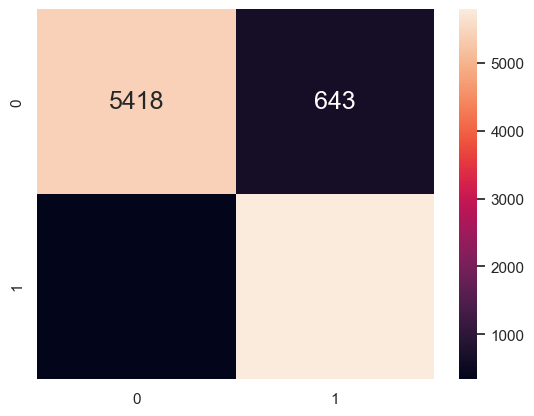

In [25]:
rf_confusion_matrix = confusion_matrix(y_test, rf_y_pred)

sb.heatmap(rf_confusion_matrix, annot=True, fmt=".0f", annot_kws={"size": 18})

In [26]:
rf_results = evaluate_model('Random Forest', y_test, rf_y_pred)

rf_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Random Forest,0.919065,0.921461,0.900047,0.943919


## Neural Network

In [27]:
def visualize_training_history(history):
    """
    Creates a visualization of model's training process that contains:
        - Loss
        - Accuracy
        - Precision
        - Recall
    """
    f, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
    f.suptitle('Training History', fontweight='bold', fontsize='x-large')

    ax[0][0].plot(history.history['loss'], label='Loss')
    ax[0][0].set_title('Loss History')
    ax[0][0].set(ylabel='Loss', xlabel='Number of Epochs')
    ax[0][0].legend(loc="upper right")

    ax[0][1].plot(history.history['accuracy'], label='Accuracy')
    ax[0][1].set_title('Accuracy History')
    ax[0][1].set(ylabel='Accuracy', xlabel='Number of Epochs')
    ax[0][1].legend(loc="lower right")

    ax[1][0].plot(history.history['precision'], label='Precision')
    ax[1][0].set_title('Precision History')
    ax[1][0].set(ylabel='Precision', xlabel='Number of Epochs')
    ax[1][0].legend(loc="lower right")

    ax[1][1].plot(history.history['recall'], label='Recall')
    ax[1][1].set_title('Recall History')
    ax[1][1].set(ylabel='Recall', xlabel='Number of Epochs')
    ax[1][1].legend(loc="lower right")

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


2024-04-24 15:26:17.871777: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1144/1144 [==============================] - 1s 777us/step - loss: 15.7538 - accuracy: 0.6733 - precision: 0.6753 - recall: 0.6652 - val_loss: 3.1843 - val_accuracy: 0.7851 - val_precision: 0.7534 - val_recall: 0.8513
Epoch 2/10
1144/1144 [==============================] - 1s 671us/step - loss: 7.9059 - accuracy: 0.7226 - precision: 0.7222 - recall: 0.7216 - val_loss: 2.5212 - val_accuracy: 0.8114 - val_precision: 0.7681 - val_recall: 0.8953
Epoch 3/10
1144/1144 [==============================] - 1s 758us/step - loss: 7.6037 - accuracy: 0.7340 - precision: 0.7334 - recall: 0.7336 - val_loss: 3.6393 - val_accuracy: 0.7073 - val_precision: 0.8697 - val_recall: 0.4918
Epoch 4/10
1144/1144 [==============================] - 1s 696us/step - loss: 6.1629 - accuracy: 0.7402 - precision: 0.7396 - recall: 0.7396 - val_loss: 1.9217 - val_accuracy: 0.8019 - val_precision: 0.8268 - val_recall: 0.7667
Epoch 5/10
1144/1144 [==============================] - 1s 729us/step - loss: 5.1552 - accuracy: 0

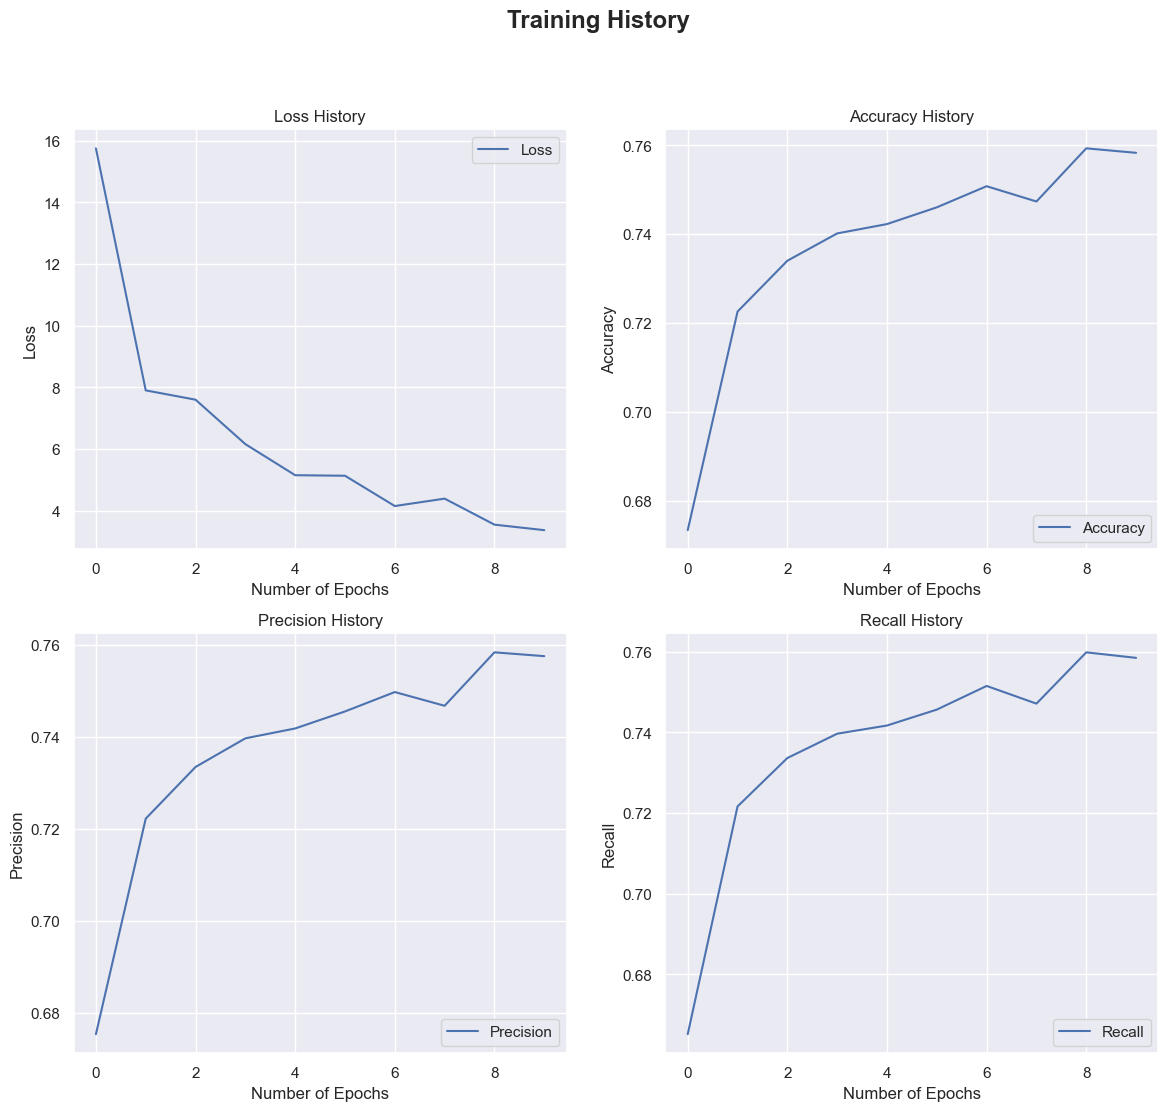

In [30]:
visualize_training_history(history)

### Evaluation

In [31]:
model.evaluate(X_test, y_test, verbose=0)

[1.5285465717315674,
 0.8221402168273926,
 0.7689594626426697,
 0.9240300059318542]

In [32]:
nn_y_pred = (model.predict(X_test) >= 0.5).astype('int64')

382/382 [==============================] - 0s 348us/step


In [33]:
nn_results = evaluate_model('Neural Network', y_test, nn_y_pred)

nn_results

,Model,Accuracy Score,F1 score,Precision,Recall
0,Neural Network,0.82214,0.839393,0.768959,0.92403


## Results

In [35]:
results = pd.concat([lr_results, knn_results, rf_results, nn_results])
results_sorted = results.sort_values(by='Precision', ascending=False)
results_sorted

,Model,Accuracy Score,F1 score,Precision,Recall
0,Random Forest,0.919065,0.921461,0.900047,0.943919
0,Logistic Regression,0.821976,0.825496,0.814175,0.837137
0,Neural Network,0.822140,0.839393,0.768959,0.924030
0,K-Nearest Neighbors,0.791226,0.802605,0.765228,0.843821
